<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install scikit-learn==1.5.1
!pip install numpy==1.26.4
!pip install matplotlib==3.9.2
!pip install seaborn==0.13.2
!pip install lightgbm==4.5.0

  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.26.4 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.
  Using cached numpy-1.24.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

Устанавливаю оптимальные версии библиотек

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

Импортирую необходимые библиотеки

In [3]:
print("Текущая версия scikit-learn:", sklearn.__version__)

Текущая версия scikit-learn: 1.5.1


In [4]:
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

Константы

In [5]:
# Функция для визуализации количественных признаков
def num_plot(data,columns):
    for column in columns:
        plt.figure(figsize=(12,3))
        # Первый график
        plt.subplot(1,2,1)
        sns.histplot(data=data,x=column,bins=50,kde=True)
        plt.title(f"Гистограмма {column}")
        plt.xlabel(f"Значения {column}")
        plt.ylabel("Количество")
        plt.grid()
        
        # Второй график
        plt.subplot(1,2,2)
        sns.boxplot(data=data,y=column)
        plt.title(f"Boxplot {column}")
        plt.xlabel("Boxplot")
        plt.ylabel(f"Значения {column}")
        plt.grid()
        plt.show()
        
# Функция для визуализации категориальных признаков
def cat_plot(data, columns):
    for column in columns:
        plt.figure(figsize=(12, 4))
        sns.countplot(x=column, data=data,palette="Set1")
        plt.title(f'Анализ частоты в столбце {column}')
        plt.xlabel(f'Значения {column}')
        plt.ylabel('Частота')
        plt.xticks(rotation=80)
        plt.grid()
        plt.show()

# Функция для визуализации синусоиды
def sin_cos_plot(data):
    # sin_hour / cos_hour
    plt.figure(figsize=(10, 4))
    plt.plot(data['hour'], data['sin_hour'], label='sin_hour')
    plt.plot(data['hour'], data['cos_hour'], label='cos_hour')
    plt.title('Визуализация sin_hour и cos_hour')
    plt.xlabel('Час')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
    
    # sin_dow / cos_dow
    plt.figure(figsize=(10, 4))
    plt.plot(data['dayofweek'], data['sin_dow'], 'o-', label='sin_dow')
    plt.plot(data['dayofweek'], data['cos_dow'], 'o-', label='cos_dow')
    plt.title('Визуализация sin_dow и cos_dow')
    plt.xlabel('День недели')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()
    
    # sin_month / cos_month
    plt.figure(figsize=(10, 4))
    plt.plot(data['month'], data['sin_month'], 'o-', label='sin_month')
    plt.plot(data['month'], data['cos_month'], 'o-', label='cos_month')
    plt.title('Визуализация sin_month и cos_month')
    plt.xlabel('Месяц')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

# Функция для визуализации сезонности, трендов и шума во временном ряду  
def seasonal_decompose_plot(result, columns, colors=['blue','green','orange','red']):
    for i in range(len(columns)):
        series = getattr(result, columns[i])
        plt.figure(figsize=(12, 4))
        plt.plot(series, color=colors[i])
        plt.title(f'Распределение {columns[i]} относительно даты')
        plt.xlabel('Дата')
        plt.ylabel(f'Значение {columns[i]}')
        plt.grid()
        plt.show()

# Функция для визуализации средних пиковых значений за временной промежуток
def mean_time_series_plot(x, y,title='час'):
    plt.figure(figsize=(12, 4))
    plt.plot(x, y, 'o-', color='blue', alpha=1, label='Значение')
    plt.fill_between(x, y, alpha = 0.2, color='blue')
    plt.title(f'График среднего количества заказов за каждый {title}')
    plt.xlabel(title.capitalize())
    plt.ylabel('Cреднее количество заказов')
    plt.grid()
    plt.legend()
    plt.show()

Функции

## Подготовка

In [6]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [8]:
data.duplicated().sum()

0

Данные были выгруженны корректно. Названия столбцов оформлены в соответствии со стилистическими нормами. Столбец datetime имеет неверный тип данных, необходимо преобразовать тип с object в datetime64. Пустые значения и явные дубликаты в датасете не обнаружены.

**Предобработка данных**

In [9]:
data_copy = data.copy()

Создаю копию для работы с изменённым датасетом

In [10]:
data_copy['datetime'] = pd.to_datetime(data_copy['datetime'],format='%Y-%m-%d %H:%M:%S')
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Тип данных успешно изменён

**Агрегация по часу**

In [11]:
data_copy = data_copy.set_index('datetime')
data_copy = data_copy.sort_index(ascending=True)
data_copy

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Теперь данные упорядоченны по дате. Первая запись в датасете содержит информацию за 1 марта 2018 года 00:00:00, а заканчивается строчкой за 31 августа 2018 года 23:50:00.

In [12]:
data_copy = data_copy.resample('1H').sum()

In [13]:
data_copy

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Просуммировал количество заказов за каждый час

**Подготовка признаков**

In [14]:
data_copy['hour'] = data_copy.index.hour
data_copy['month'] = data_copy.index.month
data_copy['dayofweek'] = data_copy.index.dayofweek

data_copy['sin_hour'] = np.sin(2 * np.pi * data_copy['hour'] / 24)
data_copy['cos_hour'] = np.cos(2 * np.pi * data_copy['hour'] / 24)
data_copy['sin_dow'] = np.sin(2 * np.pi * data_copy['dayofweek'] / 7)
data_copy['cos_dow'] = np.cos(2 * np.pi * data_copy['dayofweek'] / 7)
data_copy['sin_month'] = np.sin(2 * np.pi * data_copy['month'] / 12)
data_copy['cos_month'] = np.cos(2 * np.pi * data_copy['month'] / 12)

data_copy['shift_1'] = data_copy['num_orders'].shift(1)
data_copy['shift_2'] = data_copy['num_orders'].shift(2)
data_copy['shift_3'] = data_copy['num_orders'].shift(3)
data_copy['shift_6'] = data_copy['num_orders'].shift(6)

data_copy['rolling_3'] = data_copy['num_orders'].shift(1).rolling(3).mean()
data_copy['rolling_6'] = data_copy['num_orders'].shift(1).rolling(6).mean()
data_copy['rolling_12'] = data_copy['num_orders'].shift(1).rolling(12).mean()

Создаю признаковое описание для модели временных рядов

In [15]:
data_copy.head()

,num_orders,hour,month,dayofweek,sin_hour,cos_hour,sin_dow,cos_dow,sin_month,cos_month,shift_1,shift_2,shift_3,shift_6,rolling_3,rolling_6,rolling_12
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,3,0.000000,1.000000,0.433884,-0.900969,1.0,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,3,0.258819,0.965926,0.433884,-0.900969,1.0,6.123234e-17,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,3,0.500000,0.866025,0.433884,-0.900969,1.0,6.123234e-17,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,0.707107,0.707107,0.433884,-0.900969,1.0,6.123234e-17,71.0,85.0,124.0,NaN,93.333333,NaN,NaN
2018-03-01 04:00:00,43,4,3,3,0.866025,0.500000,0.433884,-0.900969,1.0,6.123234e-17,66.0,71.0,85.0,NaN,74.000000,NaN,NaN


In [16]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   int64  
 1   hour        4416 non-null   int64  
 2   month       4416 non-null   int64  
 3   dayofweek   4416 non-null   int64  
 4   sin_hour    4416 non-null   float64
 5   cos_hour    4416 non-null   float64
 6   sin_dow     4416 non-null   float64
 7   cos_dow     4416 non-null   float64
 8   sin_month   4416 non-null   float64
 9   cos_month   4416 non-null   float64
 10  shift_1     4415 non-null   float64
 11  shift_2     4414 non-null   float64
 12  shift_3     4413 non-null   float64
 13  shift_6     4410 non-null   float64
 14  rolling_3   4413 non-null   float64
 15  rolling_6   4410 non-null   float64
 16  rolling_12  4404 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 621.0 KB


При генерации новых признаков появились пропуски, так как методы сдвига (shift) и скользящего среднего (rolling) используют исторические данные и не имеют значений для первых строк. Заполнение таких пропусков средним или константным значением (например 0) может исказить информацию о сезонности и трендах. Благо, пропусков содержится не много (12 строк), поэтому можно запросто удалить строки с пропущенными значениями и при этом не потерять логику и объем данных.

In [17]:
data_copy = data_copy.dropna()
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4404 entries, 2018-03-01 12:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4404 non-null   int64  
 1   hour        4404 non-null   int64  
 2   month       4404 non-null   int64  
 3   dayofweek   4404 non-null   int64  
 4   sin_hour    4404 non-null   float64
 5   cos_hour    4404 non-null   float64
 6   sin_dow     4404 non-null   float64
 7   cos_dow     4404 non-null   float64
 8   sin_month   4404 non-null   float64
 9   cos_month   4404 non-null   float64
 10  shift_1     4404 non-null   float64
 11  shift_2     4404 non-null   float64
 12  shift_3     4404 non-null   float64
 13  shift_6     4404 non-null   float64
 14  rolling_3   4404 non-null   float64
 15  rolling_6   4404 non-null   float64
 16  rolling_12  4404 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 619.3 KB


Пропуски благополучно обработаны

## Анализ

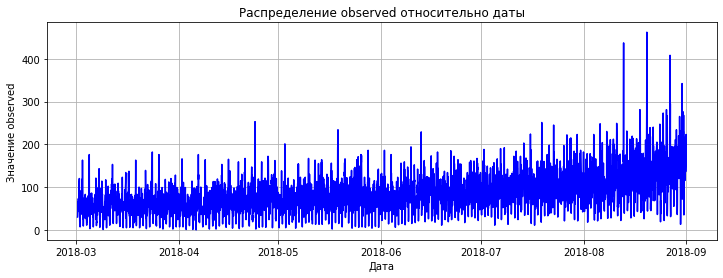

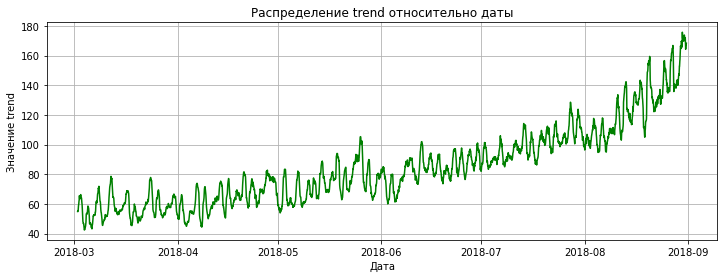

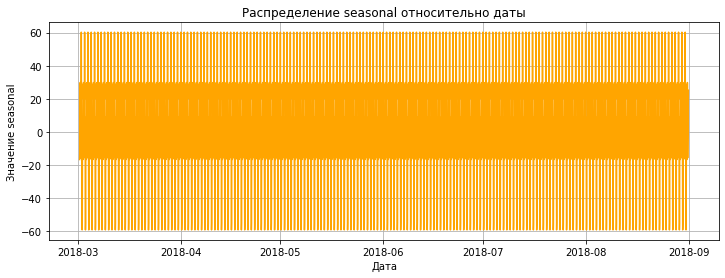

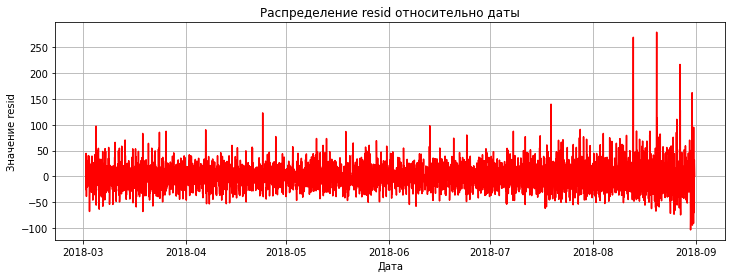

In [18]:
result = seasonal_decompose(data_copy['num_orders'], model='additive', period=24)
seasonal_decompose_plot(result,['observed','trend','seasonal','resid'])

На графике видно, что данные неоднородны: присутствуют как часы с минимальной активностью (практически нулевые заказы), так и часы с высокой пиковой загрузкой (свыше 400 заказов в час). Начиная с мая 2018 года можно заметить тенденцию к росту количества заказов, достигающую максимума в летние месяцы (особенно в августе). Это выражается как в увеличении минимальных значений, так и в появлении часов с рекордной загрузкой.

Период наблюдения ограничен семью месяцами, поэтому полноценную годовую сезонность по месяцам выявить невозможно. Тем не менее, можно предположить наличие фактора времени года, так как в летний период (июнь–август) наблюдается более высокий спрос.

In [19]:
hour_group = data_copy.groupby('hour')['num_orders'].mean()
dow_group = data_copy.groupby('dayofweek')['num_orders'].mean()
month_group = data_copy.groupby('month')['num_orders'].mean()

Делаю агрегацию по временным промежуткам и достаю средние пиковые значения

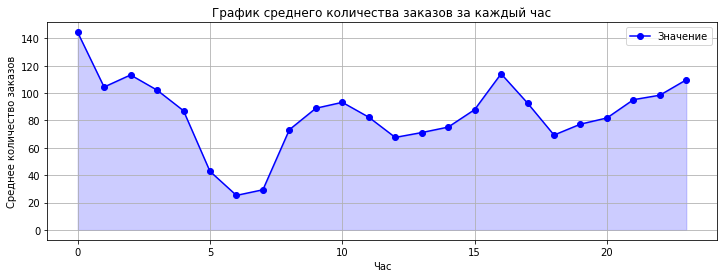

In [20]:
mean_time_series_plot(hour_group.index,hour_group.values)

Из анализа распределения заказов по часам суток видно, что минимальная активность наблюдается в ранние утренние часы (примерно с 5 до 7 утра), после чего количество заказов начинает расти, достигая заметного подъема к 8–10 часам (70-90 заказов в час). Далее днем сохраняется умеренный уровень спроса, а ближе к вечеру, начиная с 16 часов, наблюдается новый пик (114 заказов в час), который продолжается до 24 часов (144 заказа в час). Таким образом, характерная суточная сезонность выражена в двух пиках – утреннем и вечернем, что указывает на важность признака "час" для модели.

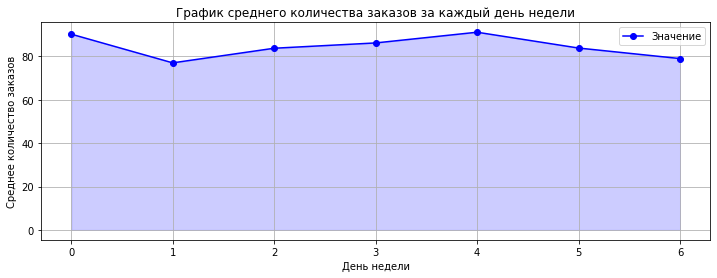

In [21]:
mean_time_series_plot(dow_group.index,dow_group.values,title='день недели')

Из графика кол-ва заказов по дням недели можно выделить следующую недельную сезонность: понедельник и пятница являются самыми доминирующими днями по среднему количеству заказов такси (90 и 91), а наименьшее среднее количество заказов во вторник (77). Также можно заметить рост количества заказов со вторника по пятницу, а с пятницы по воскресенье - спад. Следовательно, признак с днями недели содержит важные для модели закономерности и паттерны роста заказов.

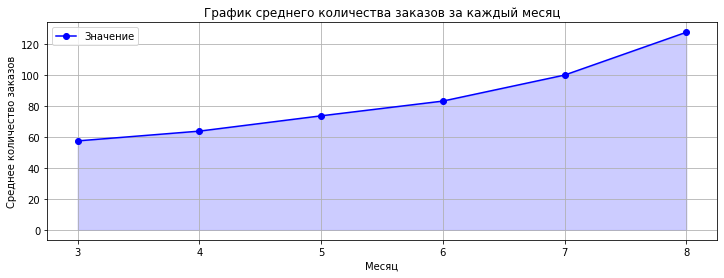

In [22]:
mean_time_series_plot(month_group.index,month_group.values,title='месяц')

Анализ динамики среднего числа заказов по месяцам показывает отчетливую тенденцию к росту спроса в летние месяцы. В марте среднее количество заказов составляет около 57.5, в апреле показатель увеличивается до 63.8, в мае - до 73.7. Далее рост становится еще более выраженным: в июне среднее значение достигает 83.2, в июле - 100.0, а максимальное значение наблюдается в августе - 127.7, что на 27% больше, чем в июле и более чем в 2 раза превышает мартовский уровень.

Такое распределение указывает на наличие ярко выраженного тренда с пиком спроса летом (особенно в августе), что необходимо учитывать при прогнозировании.

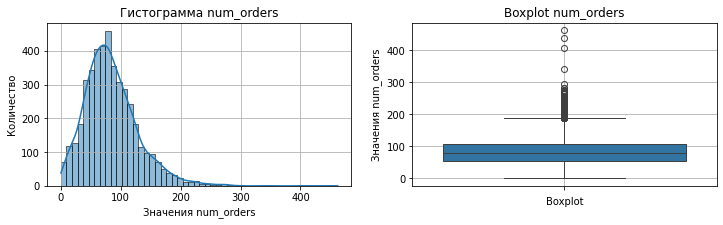

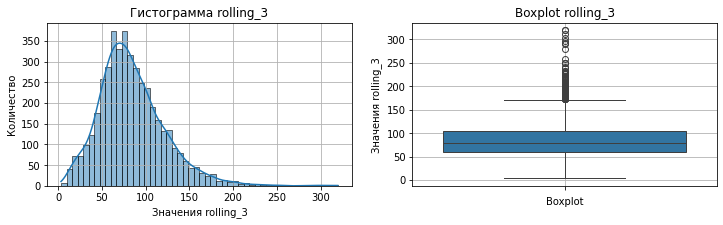

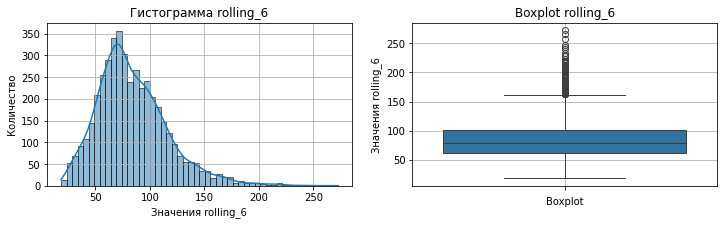

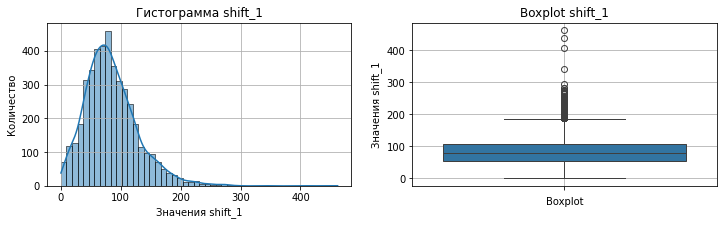

In [23]:
num_plot(data_copy,['num_orders','rolling_3','rolling_6','shift_1'])

In [24]:
data_copy[['num_orders','rolling_3','rolling_6', 'rolling_12', 'shift_1']].describe()

,num_orders,rolling_3,rolling_6,rolling_12,shift_1
count,4404.000000,4404.000000,4404.000000,4404.000000,4404.000000
mean,84.497275,84.441644,84.398653,84.308697,84.472525
std,45.026257,37.965476,32.903967,28.808040,44.989947
min,0.000000,3.333333,18.500000,28.166667,0.000000
25%,54.000000,59.666667,62.000000,62.916667,54.000000
50%,78.000000,78.666667,79.000000,80.500000,78.000000
75%,107.250000,104.666667,102.208333,99.833333,107.000000
max,462.000000,319.666667,272.333333,203.750000,462.000000


По результатам визуализационного и статистического анализа можно сделать следующие выводы:


* **num_orders:**
Распределение имеет выраженную правую асимметрию: большинство значений сосредоточено около 50–100 заказов, но есть редкие пики до 462. Медиана: 78, среднее: 84 - что также свидетельствует о положительной ассиметрии. Минимум(0) и максимум(462) - сильные выбросы или аномалии, на них стоит обратить внимание.


* **rolling_3:**
Скользящее среднее за 3 периода сглаживает пики и выбросы. Минимум 3.33, максимум 319.66. Медиана 78. Значения распределены более равномерно - хорошо отражает тренд. Может помочь модели улавливать локальные средние значения.


* **rolling_6:**
Скользящее среднее за 6 периодов ещё более сглаженное. Минимум 18.5, максимум 272.33, медиана 79. Снижение стандартного отклонения, максимума и увеличение минимума относительно rolling_3 - признак сглаживает шум и делает данные более однородными. Может использоваться для выявления долгосрочных трендов в данных.


* **rolling_12:**
Ряд, усреднённый за 12 периодов, демонстрирует сильное сглаживание колебаний. Минимальное значение составляет 28.17, максимальное — 203.75, медиана — 80.5. Рассеяние и амплитуда заметно меньше, чем у rolling_6, что говорит о том, что шум практически устраняется. Этот признак позволяет модели лучше улавливать долгосрочные тенденции и прогнозировать изменения в заказах на более стабильном уровне.


* **shift_1:**
Распределение очень похоже на num_orders, так как это сдвиг на один шаг предыдущих данных. Медиана и среднее совпадают с num_orders, минимум и максимум тоже. Признак информативен для модели, но требует обработки нулевых значений. Я решил проанализировать только этот лаг, так как остальные лаги (shift_2, shift_3, shift_6) почти полностью повторяют распределение предыдущих значений, и показывая один, мы иллюстрируем принцип работы всех остальных.

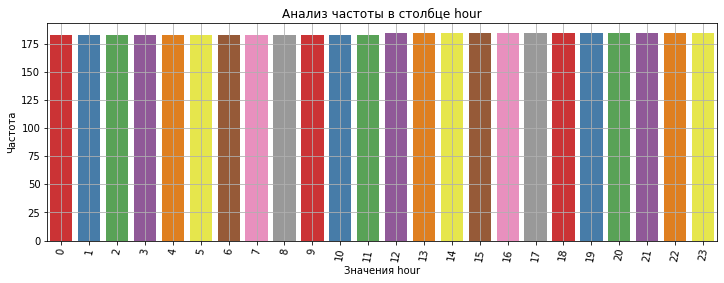

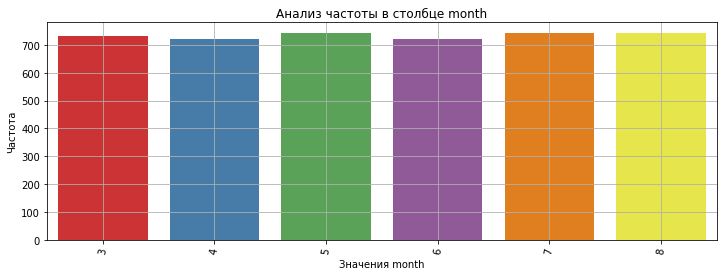

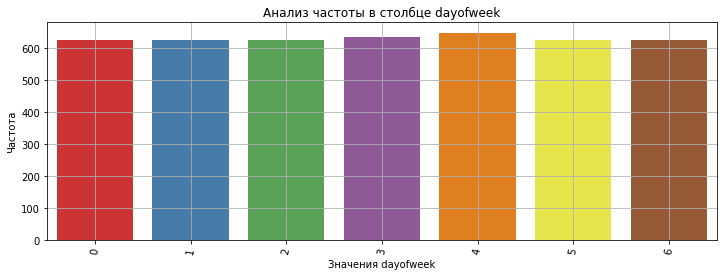

In [25]:
cat_plot(data_copy,['hour', 'month', 'dayofweek'])

По результатам анализа категориальных признаков можно сказать, что:


* **hour:** Распределение наблюдений по часам почти одинаковое - 183–184 на каждый час. Данные равномерно покрывают сутки, без явных пиков. Признак полезен для модели, так как отражает дневные колебания спроса.


* **month:** Наибольшее количество записей приходится на август, май и июль (по 744), чуть меньше — март (732), апрель и июнь (по 720). Распределение относительно равномерное, но небольшие различия помогают модели учитывать сезонные колебания спроса.


* **dayofweek:** Чаще всего встречается четверг (648), чуть реже — среда (636), остальные дни — около 624. Эти различия позволяют модели учитывать недельную сезонность и прогнозировать пики активности в определённые дни.

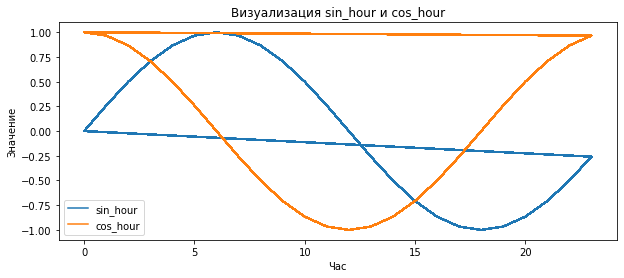

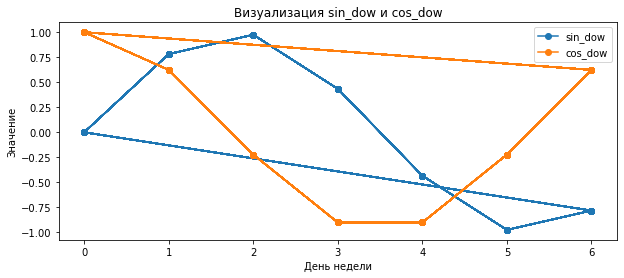

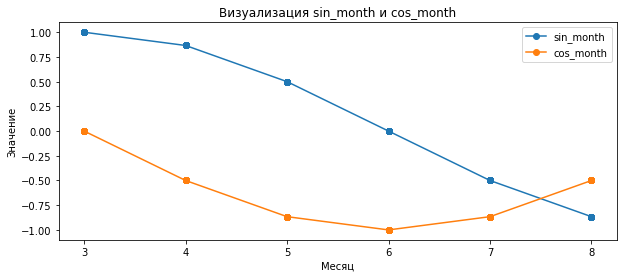

In [26]:
sin_cos_plot(data_copy)

* **sin_hour и cos_hour (часы суток):**
Значения этих признаков изменяются плавно и повторяются каждые 24 часа. Это подтверждает, что они отражают цикличность суток. Минимальное значение -1, максимальное 1 - всё в пределах ожидаемого диапазона. Резких скачков или выбросов нет. Такой подход позволяет корректно учесть повторяемость часов.


* **sin_dow и cos_dow (дни недели):**
Эти признаки изменяются по плавной волне с повторением каждые 7 дней. Например, значения для воскресенья и понедельника находятся близко друг к другу, что правильно отражает их последовательность. Все значения лежат в диапазоне [-1; 1], пропусков нет. Такое кодирование делает дни недели удобными для моделей, так как сохраняется информация о цикличности (переход от воскресенья к понедельнику не вызывает разрыва).


* **sin_month и cos_month (месяцы):**
Здесь значения также изменяются плавно. Диапазон также [-1; 1], выбросов нет. Однако в датасете есть только месяцы с марта по август, поэтому цикл представлен не полностью. Из-за этого признаки могут быть менее информативными, чем для полного года, но всё равно полезны для выявления сезонных тенденций за определённый период.

## Обучение

In [27]:
X = data_copy[['hour', 'month', 'dayofweek', 
               'shift_1', 'shift_2', 'shift_3', 'shift_6',
               'rolling_3', 'rolling_6', 'rolling_12',
               'cos_month', 'sin_month', 'sin_dow', 'cos_dow', 'cos_hour', 'sin_hour']]
y = data_copy['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False )

Разделил данные на тренировочную и тестовую выборку

In [28]:
num_col = X.columns.tolist()
data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_col)], remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'preprocessor__num': [StandardScaler(), 'passthrough']   
    },
    
    # LightGBM
    {
        "models": [LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1)],
        "models__max_depth": [2, 3, 4, 5],  
        "models__num_leaves": [15, 31, 50],  
        "models__min_child_samples": [10, 20, 30] 
    }
]

Общий пайплайн нормализации и сетки параметров

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=15
)

randomized_search.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на кросс-валидации:', -randomized_search.best_score_)


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['hour', 'month', 'dayofweek',
                                                   'shift_1', 'shift_2',
                                                   'shift_3', 'shift_6',
                                                   'rolling_3', 'rolling_6',
                                                   'rolling_12', 'cos_month',
                                                   'sin_month', 'sin_dow',
                                                   'cos_dow', 'cos_hour',
                                                   'sin_hour'])])),
                ('models',
                 LGBMRegressor(max_depth=4, min_child_samples=10, n_jobs=-1,
                               num_leaves=15, random_state=42, verbosity=-1))])
Метрика лучшей мод

В ходе реализации пайплайна для прогнозирования целевой переменной были протестированы следующие модели:LightGBM и DecisionTreeRegressor


Для подготвки данных использовался метод масштабирования данных StandardScaler. Для оценки качества модели была использована метрика RMSE


По результатам перекрёстной проверки на кросс-валидации наилучший результат показала модель:LGBMRegressor(max_depth=4, min_child_samples=10, n_jobs=-1,num_leaves=15, random_state=42, verbosity=-1) c метрикой RMSE = 24.8.

## Тестирование

In [30]:
y_pred_test = randomized_search.predict(X_test)
test_rmse = np.sqrt(np.mean((y_test - y_pred_test)**2))
print('RMSE на тестовой выборке:', test_rmse)

RMSE на тестовой выборке: 41.88743078254627


Метрика модели на тестовой выборке оказалась выше, чем на кросс-валидации (41.9 > 24.8), что говорит о некоторой нестабильности предсказаний или о наличии особенностей в тестовом наборе данных. Тем не менее, полученное значение RMSE соответствует требованиям заказчика.

**Вывод**

Цель проекта:
Построить модель, прогнозирующую количество заказов такси на следующий час для сервиса с использованием временных рядов.

<u>Предобработка и подготовка данных</u>

* Данные загружены корректно, пропусков и дубликатов не обнаружено. Столбцы приведены к единому стилю.
* Столбец datetime преобразован в тип datetime64, данные отсортированы по дате (период с 1 марта по 31 августа 2018 года).
* Для прогнозирования добавлены новые признаки: час, день недели, месяц, а также признаки цикличности (sin_hour, cos_hour, sin_dow, cos_dow, sin_month, cos_month), лаги (shift) и скользящее среднее (rolling).
* При генерации лагов и скользящего среднего возникли пропуски (12 строк), которые удалены без потери логики данных.

<u>EDA (анализ признаков)</u>

* **num_orders:** распределение с правой асимметрией, медиана 78, среднее 84, редкие пики до 462 заказов.
* **rolling-признаки:** сглаживают колебания; rolling_3 отражает локальные тренды, rolling_12 убирает почти весь шум и показывает долгосрочную тенденцию.
* **shift-признаки:** информативны для учета предыдущих значений.
* **hour:** распределение заказов по часам неравномерное, наблюдаются два выраженных пика: утренний (8–10 часов, 70–90 заказов в час) и вечерний (16–24 часа, до 144 заказов в час). Минимальная активность приходится на 5–6 утра (около 25 заказов). Это подтверждает наличие ярко выраженной суточной сезонности.
* **dayofweek:** понедельник и пятница демонстрируют наибольшее среднее количество заказов (90 и 91), минимальное значение во вторник (77). Прослеживается рост спроса со вторника по пятницу и снижение к выходным, что отражает недельную сезонность.
* **month:** наблюдается четкий рост количества заказов в летние месяцы: март 57.5, апрель 63.8, май 73.7, июнь 83.2, июль 100.0, август 127.7. Максимальный спрос фиксируется в августе (в 2 раза выше мартовского уровня), что указывает на сильную сезонность по месяцам и необходимость учета тренда.

*sin/cos признаки:*

* sin_hour, cos_hour отражают цикличность часов (повтор каждые 24 часа), без выбросов.
* sin_dow, cos_dow показывают плавную смену дней недели, сохраняя цикличность (переход воскресенье → понедельник).
* sin_month, cos_month отражают сезонность, но цикл неполный (март–август), информативность ограничена.

<u>Модели и результаты</u>

Для прогнозирования количества заказов такси за следующий час использовались следующие модели: DecisionTreeRegressor и LightGBM.
Метрика для оценки качества модели - RMSE.


Лучший результат показала LightGBM с параметрами:
max_depth=4, min_child_samples=10, num_leaves=15. Значение метрики на кросс-валидации: 24.8,но предсказания на тестовой выборке менее точные. RMSE на тестовой выборке: 41.9


Разница между кросс-валидацией и тестом (24.8 < 41.9) указывает на возможные особенности тестовых данных: наличие новых трендов или сезонности, которые модель не учла, но итоговое качество соответствует требованиям заказчика.

<u>Рекомендации для заказчика:</u>

Учитывать выраженные суточные и недельные пики спроса (утренний и вечерний периоды, загруженные дни недели) для оптимального планирования смен и распределения водителей, а также летний рост количества заказов на период с марта по август, чтобы обеспечить достаточную пропускную способность и качество сервиса.